In [1]:
# Set Autoreload on python notebooks
%load_ext autoreload
%autoreload 2

# Django, Geopandas, etc related setup.

import os, sys
# PROJECTPATH = os.getcwd()
PROJECTPATH = os.environ["PWD"]
sys.path.insert(0, PROJECTPATH)
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "mygeo.settings")
os.environ.setdefault("DJANGO_PROJECT", "mygeo")
os.environ.setdefault("LOCAL_DB", "1")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
os.chdir(PROJECTPATH)
import django
django.setup()

import json
import pprint
import geopandas
import shapely
from django.core.serializers import serialize
from shapely.geometry import GeometryCollection
from shapely.ops import triangulate

from world.models import Parcel, ZoningBase, BuildingOutlines

print("INITIALIZATION DONE")



**** RUNNING IN (insecure) DEVELOPMENT MODE ****
****** LOCAL DATABASE ******


INITIALIZATION DONE


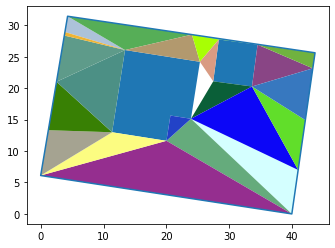

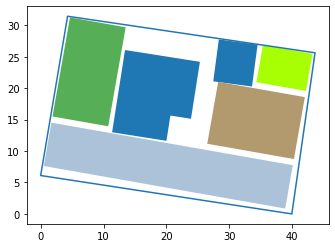

In [106]:
# ALGORITHM: Find biggest rectangles that fit on a parcel.
from notebooks.notebook_util import nb_exit, display_polys_on_lot
from lib.parcel_lib import *
from shapely.geometry import MultiPolygon
import pandas as pd
# from lib.parcel_lib import *

apn = '4302030800'
# apn = '4255451500'

# Get parcel and building info for this apn.
parcel = get_parcel(apn)
buildings = get_buildings(parcel)

# convert building and parcel data into a UTM projection, which is a flat
# geometry where each unit is 1 meter.
parcel_in_utm = parcel_to_utm_gdf(parcel)
buildings_in_utm = buildings_to_utm_gdf(buildings)
# lot_square_meters = parcel_in_utm.area
# print ("Lot: ", lot_square_meters)
# print ("buildings: ", buildings_in_utm.area)

# do some basic sanity checks
assert (len(parcel_in_utm.boundary[0].geoms) == 1)
# assert (len(buildings_in_utm.boundary) == 2)
assert (len(buildings_in_utm.boundary[0].geoms) == 1)

# TODO: Algorithm currently only uses first building. extend it to multiple buildings
# building_lines = MultiLineString(buildings_in_utm.geometry)
assert (len(parcel_in_utm.boundary) == 1)

# Why does building have to be a line_string but parcel isn't?
# Why do we have to treat buildings as a line string and not as a polygon that can be filled in?
# Is this something to do with the building's data structure (not having information on the fill, only vertices)?
parcel_boundary_multipoly, buildings = normalize_geometries(parcel_in_utm, buildings_in_utm)

# Calculate the available geometries
avail_geom = get_avail_geoms(parcel_boundary_multipoly, buildings)

# A lot data frame contains the building(s) and the parcel (the plot of land)
lot_df = geopandas.GeoDataFrame(geometry=[*buildings, parcel_boundary_multipoly.boundary], crs="EPSG:4326")
# Display a graphic showing the building(s), and the available geometries we've calculated
display_polys_on_lot(lot_df, avail_geom.geoms)

# Now find the largest rectangles we can fit on the available geometries
placed_polys = find_largest_rectangles_on_avail_geom(avail_geom, 4)

display_polys_on_lot(lot_df, placed_polys)
# nb_exit()


In [78]:
## NOT WORKING: Find rectangles: Implementation attempt from old Dr Dobbs journal.
# Ref: https://stackoverflow.com/questions/7245/puzzle-find-largest-rectangle-maximal-rectangle-problem
# and https://www.drdobbs.com/database/the-maximal-rectangle-problem/184410529

def not_working():
    from rasterio import features
    raster_dims = [30,33]
    b = features.rasterize(kept_triangles, raster_dims)
    cache = [0] * (raster_dims[0]+1)
    stack = []
    best_rect = ((0,0),(-1,-1))
    best_area = 0
    def update_cache(x):
        for y in range (0, 30):
            if (b[y][x]==1): # inside polygon
                cache[y] = cache[y]+1
                #print (f'Cache @ y={y} : {cache[y]}')
            elif (b[y][x]==0):
                cache[y] = 0
            else:
                print ("Unkknown b value: ", b[y][x])

    for x in range(32,-1,-1):
        update_cache(x)
        open_width=0  # width of widest open rect
        for y in range(31):
            # print ("X,Y is ", x, y)
            if (cache[y] > open_width): # opening new rectangle(s)
                stack.append((y, open_width))
                print (f'{x},{y} OPEN. Push (y, open_width) =({y}, {open_width})')
                open_width = cache[y]
            elif (cache[y] < open_width):
                while (cache[y] < open_width): # closing rectnagles
                    (y0, w0)= stack.pop()
                    print (f'{x},{y} CLOSING popped y0,w0 = ({y0}, {w0})')
                    area = open_width*(y-y0)
                    if (area > best_area):
                        best_area = area
                        best_rect = ((x, y0), ((x-open_width+1), y-1))
                        print ("  BETTER Rect:", best_rect, " . Area=", best_area)
                    open_width = w0
                open_width = cache[y]
                if (open_width != 0): # popped an active opening
                    stack.append ((y0, open_width))

    print (best_rect)
    print (cache)


In [ ]:
# MIRA MESA NEIGHBORHOOD:
(-117.17987773162996, 32.930825570911985), (-117.12513392170659, 32.894946222075184)